In [ ]:
#librerias==============================================================

import numpy as np
from scipy.interpolate import CubicSpline
import sympy as sp
import scipy as sc
from scipy import optimize
import pandas as pd
from scipy.misc import derivative
from sympy import init_printing
import matplotlib.pylab as plt
init_printing() 
import scipy.interpolate as interpolate
import scipy.integrate as integrate
from scipy.integrate import quad

#1.0 Derivadas

El metodo Smoothed-particle hydrodynamics (SPH) es un método computacional utilizado para simular la dinámica de medios continuos, tales como la mecánica de sólidos y los flujos de fluido. En este metodo se emplean diferentes kernel de aproximación para calcular las propiedades del fluído en cada punto del espacio. Uno de ellos es el Kernel de Lucy detallado a continuación:

$W(R,h)=\alpha_d\{\frac{(1+3R)(1-R)^3}{0}$

$R=\frac{r}{h}=\frac{||r-r'||}{h}$

Se divide el fluido en un conjunto de elementos discretos, (partículas)
separadas una distancia espacial conocida como "longitud de suavizado" (h)


**$r$** es el vector posción de la particula central, **$r'$** el vector posición de la particula vecina.

##Kernel de Lucy 1D

In [ ]:
#tomando cada particula del fluido como un vector en una dimension
def R(r0,r,h):
  r=r0-r     #vector 
  r1=abs(r)  # modulo del vector r
  R=r1/h
  return R

def W(R,h):
  a=5/np.pi*h**2
  if 0<=R and R<=1:
    q=a*(1+3*R)*(1-R)**3
  else:
    q=0
  return q

In [ ]:
r0=0                       # vector posicion de la particula de referencia
h=2                        #longitud de suavizado
x = np.linspace(-1, 1,30 ) #conjunto de vectores vecinos



In [ ]:
valR=R(r0,x,h)# array de los valores de la funcion R evaluado en las 
              #posiciones de las particulas vecinas

In [ ]:
valW=np.zeros(len(valR)) #array donde se guarga el valor de W

for i in range(len(valR)): # evalua W en cada punto obtenido en la funcion R
  valW[i]=W(valR[i],h)

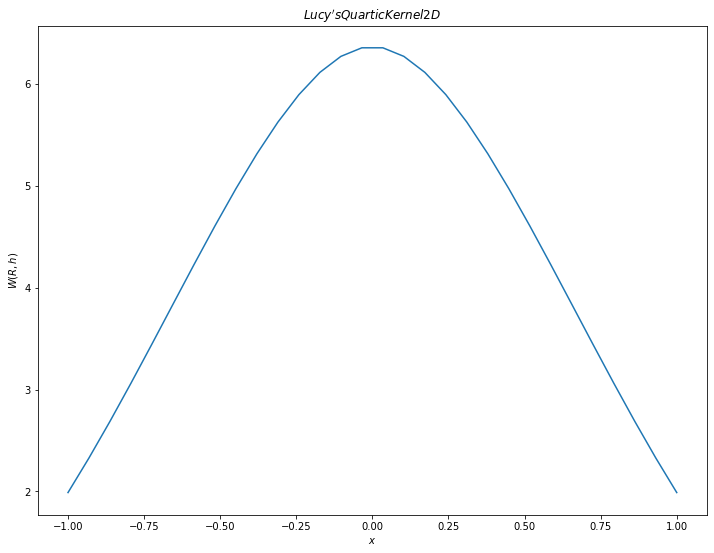

In [ ]:
#grafico del kernel=========================================================================

plt.figure(figsize=(12,9))
plt.xlabel('$x$')
plt.ylabel('$W(R,h)$')
plt.title("$Lucy's Quartic Kernel  2D$")
plt.plot(x,valW)


In [ ]:
#funcion para encontrar la derivada 
derivada = np.vectorize(derivative ) #Convierte derivative en una función numpy

In [ ]:
#Con valW y x tenemos los puntos de la grafica del kernel

FW= CubicSpline(x,valW)       #Función que interpola los puntos
DW=derivada(FW,x,dx=0.0001)   #puntos de la derivada de w

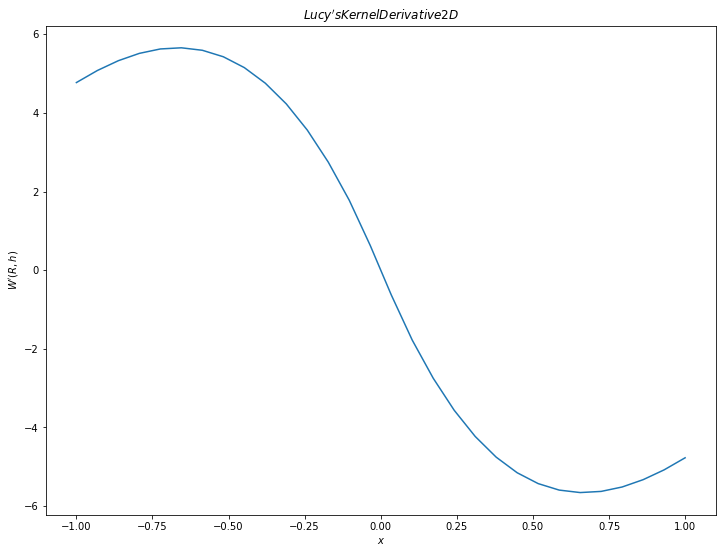

In [ ]:
#grafico de la derivada del kernell=============================================

plt.figure(figsize=(12,9))
plt.xlabel('$x$')
plt.ylabel("$W'(R,h)$")
plt.title("$Lucy's Kernel Derivative 2D$")
plt.plot(x,DW)


##Kernel de Lucy 2D

Tomando cada particula del fluido como un vector en dos dimensiones

In [ ]:
def R(r0,r,h):
  r=r0-r                       #vector 
  r1=np.sqrt(r[:,0]**2+r[:,1]**2)  # modulo del vector r, distancia entre r y r'
  R=r1/h
  return R

@np.vectorize
def W(R,h):
  a=105/16*np.pi*h**3
  if 0<=R and R<=1:
    q=a*(1+3*R)*(1-R)**3
  else:
    q=0
  return q

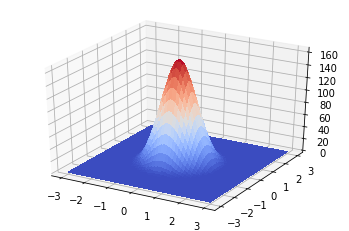

In [ ]:

r0=np.array([0,0])
h=2
# Make data.
X = np.linspace(-3, 3,100)
Y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(X, Y)
r1=np.sqrt(X**2+Y**2)  # modulo del vector r, distancia entre r y r'
R=r1/h
Z=W(R,h)


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#2.0 Integración
##Métodos de integración

###Regla del trapecio

Tenemos dos puntos $[x_0,x_1]$ y conocemos el valor de $f(x)$ en estos. Se aproxima la funcion con un polinomio lineal de Lagrange dado por:

$$P_1(x) = \frac{(x-x_1)}{x_0-x_1}f(x_0) + \frac{(x-x_0)}{(x_1-x_0)}f(x_1)$$

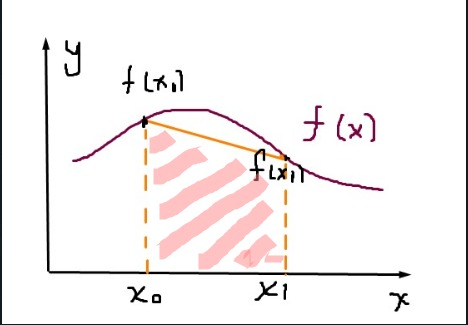

 Error de aproximación del polinomio$$\frac{1}{2}f^{''}(\xi)(x-x_0)(x-x_1)$$

Intengrando el polinomio

$$\int_{x_0}^{x_1}f(x)dx \approx\int_{x_0}^{x_1} \frac{(x-x_1)}{x_0-x_1}f(x_0) + \frac{(x-x_0)}{(x_1-x_0)}f(x_1)  dx$$

$$\int_{x_0}^{x_1}f(x)dx \approx \frac{f(x_0)}{x_0-x_1}\int_{x_0}^{x_1} (x-x_1)dx + \frac{f(x_1)}{(x_1-x_0)}\int_{x_0}^{x_1}(x-x_0) dx$$

$$\int_{x_0}^{x_1}f(x)dx\approx\frac{f(x_0)}{2(x_0-x_1)}\left[(x-x_1)^2\right]+ \frac{f(x_1)}{2(x_1-x_0)}(x-x_0)^2 $$



$$\int_{x_0}^{x_1}f(x)dx \approx \frac{h}{2}[ f(x_0) + f(x_1) ]$$

con $\xi \in [x_0, x_1]$ y $h = x_1-x_0$.

Intengrando el error

$$
\int_{x_0}^{x_1} f''(\xi(x))(x-x_0)(x-x_1) \, dx = f''(\xi(x))\int_{x_0}^{x_1} (x-x_0)(x-x_1) \, dx
$$
$$ = f''\xi(x) [\frac{x^3}{3}-\frac{(x_1+x_0)}{2}x^2+x_0x_1x]^{x_1}_{x_0} $$
$$= -\frac{h^3}{6}f''(\xi) $$

####Generalización del método

Se generaliza el metodo, buscando la integral de una funcion $f$ cuya gráfica pasa por los puntos  $(x_0,f(x_0)),(x_1,f(x_1)),...,(x_i,f(x_i)), ..., (x_{n-1},f(x_{n-1}))$

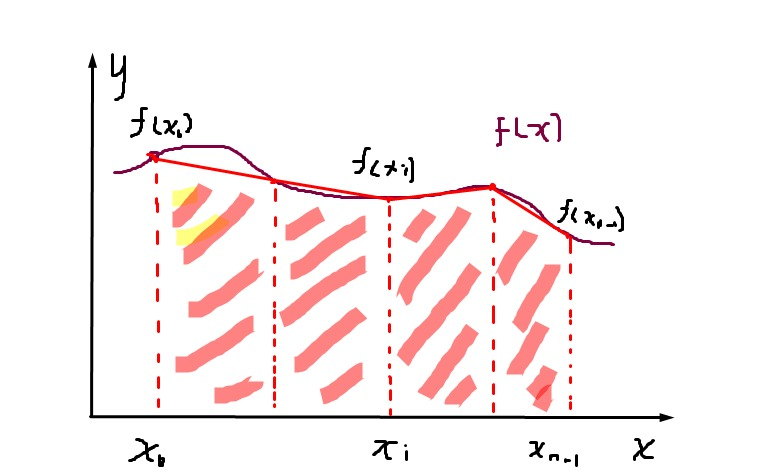

El mismo proceso anterior se hace para obtener la integral aproximada entre cada dos puntos sucesivos $ x_i$ y $x_{i+1}$. Entonces la integral total aproximada desde el punto $x_1$ al punto $x_{n-1}$ corresponde a la suma de todas las areas obtenidas en el paso anterior. 


$$\int_{x_i}^{x_{i+1}}f(x)dx \approx  \frac{h}{2}[ f(x_i) + f(x_{i+1}) ]-\frac{h^3}{12}f^{''}(\xi)$$

con $\xi \in [x_0, x_1]$ y $h = x_1-x_0$.

$$\sum_{i=0}^{N-1}  \int_{i}^{x_{i+1}} f(x)\,dx
  \approx   \frac{h}{2} \sum_{i=0}^{N-1}(f(x_i)+f(x_{i+1})) 
    - \frac{(b-a) h^2}{12}f''(\xi),
  $$


$$
  \int_{a}^{b} f(x)\,dx 
  \approx   \frac{h}{2} \sum_{i=0}^{N-1}(f(x_i)+f(x_{i+1})) 
    - \frac{(b-a) h^2}{12}f''(\xi),
  $$

donde $\xi\in [b,a]$, $h=a-b$

Se generaliza el metodo de interpolacion, construyendo un polinomio lineal que pase por los puntos  $(x_0,f(x_0)),(x_1,f(x_1)),...,(x_i,f(x_i)), ..., (x_{n-1},f(x_{n-1}))$

$$
  \int_{a}^{b} f(x)\,dx 
  = \sum_{i=0}^{N-1}  \int_{i}^{x_{i+1}} f(x)\,dx
  =  \frac{h}{2} \sum_{i=0}^{N-1}(f(x_i)+f(x_{i+1})) 
    - \frac{(b-a) h^2}{12}f''(\xi),
  $$

donde $\xi\in [b,a]$, $h=a-b$

$$
  \int_{a}^{b} f(x)\,dx 
  = \sum_{i=0}^{N-1}  \int_{i}^{x_{i+1}} f(x)\,dx
  =  \frac{h}{2} \sum_{i=0}^{N-1}(f(x_i)+f(x_{i+1})) 
    - \frac{(b-a) h^2}{12}f''(\xi),
  $$

donde $\xi\in [b,a]$, $h=a-b$

###Regla de Simpson

Para la regla de Simpson se interpola la funcion con tres puntos  $(x_i,f(x_i)),(x_{i+1},f(x_{i+1})),(x_{i+2},f(x_{i+2}))$usando el segundo polinomio de interpolación de Lagrange.


 En general, la regla de simpson es
 
$$
 \int_a^b f(x)dx = \frac{h}{3}\left[f(a) + 2\sum_{i=1}^{(n-1)}f(x_{2i}) + 4\sum_{i=1}^{n}f(x_{2i-1}) + f(b)\right]-\frac{b − a}{180}h^4f^{(4)}(\xi)
,$$
 
 donde $\xi ∈ (a,b).$
error=0.001


La regla de Simpson resulta de la integración sobre "[a,b] del segundo polinomio deLagrange con nodos igualmente espaciados$X_0=a,X_2=b$ y $X_1=a+h$ donde $h=\frac{(b-a)}{2}$.
Por lo tanto:
$$ \int_{a}^{b} f(X)\, dx = \int_{X_0}^{X_2} [\frac{(x-x_1)-(x-x_2)}{(x_0-x_1)-(x_0-x_2)}f(X_0)+\frac{(x-x_0)-(x-x_2)}{(x_1-x_0)-(x_1-x_2)}f(x_1)+\frac{(X-X_0)-(x-x_1)}{(x_2-x_0)-(x_2-x_1)}f(X_2) ] \, dx + \int_{x_0}^{x_2} \frac{(x-x_0)(x-x_1)(x-x_2)}{6}f^{(3)}(\xi(x)) \, dx $$

Al deducir la regla de Simpson de esta forma, sin embargo, da un solo término de error $O(h^4)$ relacionado con $f^3$. 
Al aproximar el problema de otra forma, se puede derivar otro términode orden superior relacionado con $f^4$.
Para ilustrar este método alternativo, suponga que $f$ se expande en el tercer polinomio deTaylor alrededor de $X_1$. Entonces, para cada $X$ en $[X_0,X_2]$, 
existe un número $\xi(X)$ en $(X_0,X_2)$ con
$$f(X) = f(X_1) + f'(X_1)(X-X_1) + \frac{f''(x_1}{2}(X-X_1)^2 + \frac{f'''(x_1}{6}(x-x_1)^3 +\frac{f^{(4)}X_1}{24}(x-x_1)^4 $$ 
\begin{equation} \tag{1}
 \int_{x_0}^{x_2} f(X)\, dx = [f(x_1)(x-x_1) + \frac{f''(x_1)}{2}(x-x_1)^2 + \frac{f'(x_1)}{6}(x-x_1)^3 +\frac{f´´(x_1)}{24}(x-x_1)^4]^{x_2}_{x_0} +\frac{1}{24} \int_{x_0}^{x_2} f^{(4)}(\xi(x)) (x-x_1)^4 \, dx   
\end{equation}
Puesto que $ (x-x_1)$ nunca es negativo en $[x_0,x_2]$, el teorema de valor promedio ponderadopara las integrales, implica que:

$$ \frac{1}{24} \int_{x_0}^{x_2} f^{(4)}(\xi(X)) (x-x_1)^4 \, dx = \frac{f^{(4)}(\xi_1)}{24}  \int_{x_0}^{x_2}  (X-X_1)^4 \, dx = [\frac{f^{(4)}(\xi_1)}{120} (x-x_1)^5]^{x_2}_{x_0} $$

Para algun numero $\xi_1$ en $(x_0,x_2)$. Sin embargo $h=x_2-x_1=x_1-x_0$ por lo que $$ (x_2-x_1)^2-(x_0-x_1)^2 = (x_2-x_1)^4 - (x_0-x_1)^4 = 0 $$
mientras 
$$ (x_2-x_1)^3-(x_0-x_1)^3 =2h^3 $$ y $$ (x_2-x_1)^5-(x_0-x_1)^5 =2h^5. $$
Por consiguiente la ecuación (1) se puede escribir como:
$$ \int_{x_0}^{x_2} f(x)\, dx =2hf(x_1) + \frac{h^3}{3}f''(x_1)+\frac{f^{(4)}(\xi_1)}{60}h^5 $$
Ahora, si reemplazamos $f''(x_1)$ por medio de la aproximación del punto medio de la segunda derivada, tenemos:
$$ \int_{x_0}^{x_2} f(x)\, dx =2hf(x_1) + \frac{h^3}{3}({\frac{1}{h^2}|f(x_0)-2f(x_1)+f(x_2)|-\frac{h^5}{36}f^{(4)}(\xi_2)}) +\frac{f^{(4)}(\xi_1)}{60}h^5$$ $$ =\frac{h}{3}|f(x_0)+4f(x_1)+f(x_2)|- \frac{h^5}{12}[\frac{1}{3}f^{(4)}(\xi_2)-\frac{1}{5}f^{(4)}(\xi_1)]  $$
Se puede demostrar que los valores $xi_1$ y $\xi_2$ en esta expresión se puede reemplazar mediante un valor común $\xi$ en $(x_0,x_2)$. Esto da la regla de Simpson.
$$ \int_{x_0}^{x_2} f(x)\, dx =\frac{h}{3} |f(x_0)+4f(x1)+f(x_2)|-\frac{h^5}{90}f^{(4)}(\xi)$$

El término de error en la regla de Simpson implica la cuarta derivada de
 $f$, por lo que daresultados exactos cuando se aplica a cualquier polinomio de grado tres o menos.

###Método de cuadratura


Dada una función de buen comportamiento $f(x)$, tenemos

$$f(x) \approx \sum_{k=0}^n f(x_k)L_{n,k}(x)$$

\begin{align}
%$$ trick notebook cell
\int_a^b f(x)dx =& \int_a^b\sum_{k=0}^n f(x_k)L_{n,k}(x)dx \\
=&\sum_{k=0}^n f(x_k) \int_a^b L_{n,k}(x)dx \\
=&\sum_{k=0}^n f(x_k) \omega_k \,
%$$
\end{align}

donde $\omega_k$  es un peso aplicado a cada valor de función:
$$\omega_k = \int_a^b L_{n,k}(x) dx= \int_a^b\prod_{j=0,\ j\neq k}^{n}\frac{(x-x_j)}{(x_k-x_j)}dx$$

Los polinomios de Lagrange no dependen de la función, podemos calcular analíticamente los pesos $ \omega_i $ usando solo los nodos $[x_0,x_1,\ldots x_n]$, 

$$
\int_0^1 e^{1-x^2}\, dx
$$


In [ ]:
#regla del trapecio.

b=1
a=0
epsilon=1e-5

x = sp.symbols("x") #Definicion de x como simbolo.
f= sp.exp((1 - x**2))#Definicion de la función 

f2 = sp.diff(f, x, 2)#segunda derivada de la funcion

fxn5 = sp.lambdify(x, f2, 'numpy') #numpy funcion

x_ = np.linspace(-1, 1)

#maximo de la funcion 
Max = np.max(fxn5(x_))
#print(Max)
h=sp.sqrt((12*epsilon)/((b-a)*Max)) #El tamaño de cada paso

N = int((b-a)/h) #numero de intervalos

xp = np.linspace(a, b, N+1)

x_interior = xp[1:-1]  #Puntos del interior

g=sp.lambdify(x,f,'numpy')

T1 =  (g(a))
T3 =  (g(b))
T2 =  np.sum(g(x_interior))

trap_f = T1 + 2*T2 + T3
trap_f = 0.5*h*trap_f

print("El valor de la integral es: %.8lf " %trap_f)

El valor de la integral es: 2.02850470 


In [ ]:
#simpson
def simpson(f, a, b, N):
    """
    Aproxima la integral de $f$ en $[a,b]$ mediante la fórmula compuesta 
    de Simpson con N subintervalos
    """
    n_nodos = 2*N+1 # (N+1 extremos de subintervalos) + (N puntos medios)
    x = np.linspace(a, b, n_nodos)

    x_impar = x[1: :2] # Nodos con coordenada impar (ptos medios)
    x_par = x[2:n_nodos-1:2] # Nodos con coordenada par (salvo el primero y el último)

    h = (b-a)/(2*N) # Distancia entre dos nodos de integración
    cuad = h/3*(f(a) + 2*sum(f(x_par)) + 4*sum(f(x_impar)) + f(b)) # F. comp. de Simpson
    return cuad  
x = simpson(g, 0, 1, 20)
print("El valor de la integral por el metodo de simpson es: ", x)

El valor de la integral por el metodo de simpson es:  2.0300784779579635


In [ ]:
#metodo de cuadratura
x=np.linspace(0,1,100)

def f(x):
  y=np.e**((1 - x**2))
  return y
quad(f, 0, 1)[0]

$$
\int_{-\infty}^{\infty} \frac{1}{1+x^2} \, dx
$$
$$
x= tan(u)<=> u=tan^{-1}(x), dx=sec^{2}(u)du
$$
$$x \longrightarrow -\infty = u \longrightarrow \frac{-\pi}{2} $$
$$x \longrightarrow \infty = u \longrightarrow \frac{\pi}{2} $$
por tanto la integral queda:
$$
\int_{\frac{-\pi}{2}}^{\frac{\pi}{2}} \frac{sec^2(u)}{1+tan^2(x)} \, du = \int_{\frac{-\pi}{2}}^{\frac{\pi}{2}} 1 \, du
$$


In [ ]:
b=sp.pi/2
a=-sp.pi/2

x = sp.symbols("x") #Definicion de x como simbolo.
f= (1)#Definicion de la función 

f2 = sp.diff(f, x, 2)#segunda derivada de la funcion

fxn5 = sp.lambdify(x, -f2, 'numpy') #numpy funcion

x_ = np.linspace(-np.pi, np.pi)
fp=optimize.fmin_powell( fxn5, 0.1,  ftol=1E-7 )

#este metodo no funciona puesto que no se puede hallar h manuekmante ya que el maximo es 0 no se puede dividor entre 0
#h=sp.sqrt((12*epsilon)/((b-a)*Max))

#maximo de la funcion 
#Max = np.max(fxn5(x_))
#print(Max)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 13


In [ ]:
#metodo trapecio

x=np.linspace(-np.pi/2,np.pi/2,100)

def f(x):
  y=1
  return y

g=np.vectorize(f)
g(x)
integrate.trapz(g(x),x,dx=0.00001)

In [ ]:
#metodo simpson
integrate.simps(g(x),x,dx=0.0001)

In [ ]:
#metodo de la cuadratura
quad(f, -np.pi/2, np.pi/2)[0]


$$
\int_{0}^{\pi/4} \int_{\sin x}^{\cos x} (2y\sin x +\cos^2 x)\, dxdy = \int_{0}^{\pi/4} \int_{\sin x}^{\cos x} (2y\sin x +\cos^2 x)\, dydx
$$
resolviendo la primera integral:
$$
\int_{\sin x}^{\cos x} (2y\sin x +\cos^2 x)\, dy = cos^3(x)-cos^2(x)sin(x)+sin(x)cos(2x)
$$
por tanto se resuelve la siguiente integral:
$$
\int_{0}^{\pi/4}  cos^3(x)-cos^2(x)sin(x)+sin(x)cos(2x) \, dx
$$

In [ ]:
#regla del trapecio.

b=np.pi/4
a=0
epsilon=1e-5

x = sp.symbols("x") #Definicion de x como simbolo.

y1=(sp.cos(x))**3
y2=-(sp.sin(x))*(sp.cos(x))**2
y3=sp.sin(x)*sp.cos(2*x)
f= y1+y2+y3#Definicion de la función 

f2 = sp.diff(f, x, 2)#segunda derivada de la funcion

fxn5 = sp.lambdify(x, f2, 'numpy') #numpy funcion

x_ = np.linspace(-1, 1)

#maximo de la funcion 
Max = np.max(fxn5(x_))
#print(Max)
h=sp.sqrt((12*epsilon)/((b-a)*Max)) #El tamaño de cada paso

N = int((b-a)/h) #numero de intervalos

xp = np.linspace(a, b, N+1)

x_interior = xp[1:-1]  #Puntos del interior

g=sp.lambdify(x,f,'numpy')

T1 =  (g(a))
T3 =  (g(b))
T2 =  np.sum(g(x_interior))

trap_f = T1 + 2*T2 + T3
trap_f = 0.5*h*trap_f

print("El valor de la integral es: %.8lf " %trap_f)

El valor de la integral es: 0.50709174 


In [ ]:
#simpson
def simpson(f, a, b, N):
    """
    Aproxima la integral de $f$ en $[a,b]$ mediante la fórmula compuesta 
    de Simpson con N subintervalos
    """
    n_nodos = 2*N+1 # (N+1 extremos de subintervalos) + (N puntos medios)
    x = np.linspace(a, b, n_nodos)

    x_impar = x[1: :2] # Nodos con coordenada impar (ptos medios)
    x_par = x[2:n_nodos-1:2] # Nodos con coordenada par (salvo el primero y el último)

    h = (b-a)/(2*N) # Distancia entre dos nodos de integración
    cuad = h/3*(f(a) + 2*sum(f(x_par)) + 4*sum(f(x_impar)) + f(b)) # F. comp. de Simpson
    return cuad  
x = simpson(g, 0, 1, 20)
print("El valor de la integral por el metodo de simpson es: ", x)

El valor de la integral por el metodo de simpson es:  0.463922708588527


In [ ]:
#otra manera de hacer el metodo del trapecio
x=np.linspace(0,np.pi/4,100)

def f(x):
  #y=((np.cos(x))**2)-((np.cos(x)**2)*(np.sin(x)))+(np.sin(x)*np.cos(2*x))
  y1=(np.cos(x))**3
  y2=-(np.sin(x))*(np.cos(x))**2
  y3=np.sin(x)*np.cos(2*x)
  y=y1+y2+y3
  return y

g=np.vectorize(f)
g(x)
integrate.trapz(g(x),x,dx=0.00001)

In [ ]:
#otra maner de hacer el metodo de simpson
integrate.simps(g(x),x,dx=0.0001)

In [ ]:
#metodo de la cuadratura
quad(f,0, np.pi/4)[0]

$$
\int_{e}^{2e} \frac{1}{\ln x} \, dx
$$

In [ ]:
#regla del trapecio.

b=2*np.e
a=np.e
epsilon=1e-5

x = sp.symbols("x") #Definicion de x como simbolo.

f= (1/sp.ln(x))#Definicion de la función 

f2 = sp.diff(f, x, 2)#segunda derivada de la funcion

fxn5 = sp.lambdify(x, f2, 'numpy') #numpy funcion

x_ = np.linspace(-1, 1)

#maximo de la funcion 
#Max = np.max(fxn5(x_))
#print(Max)
Max=optimize.fmin_powell( fxn5, 0.1,  ftol=1E-7 )
"""
h=sp.sqrt((12*epsilon)/((b-a)*Max)) #El tamaño de cada paso

Como el maximo es muy grande h tiende a ser 0 por tanto no se puede hacer de esta manera.
"""

Optimization terminated successfully.
         Current function value: -6943125348848170687177585370071040.000000
         Iterations: 8
         Function evaluations: 304


<string>:2: RuntimeWarning: invalid value encountered in log


'\nh=sp.sqrt((12*epsilon)/((b-a)*Max)) #El tamaño de cada paso\n\nComo el maximo es muy grande h tiende a ser 0 por tanto no se puede hacer de esta manera.\n'

In [ ]:
#metodo del trapecio
x=np.linspace(np.e,2*np.e,100)

def f(x):
  y=(1/np.log10(x))
  return y
g=np.vectorize(f)
g(x)
integrate.trapz(g(x),x,dx=0.00001)

In [ ]:
#metodo simpson
integrate.simps(g(x),x,dx=0.0001)

In [ ]:
#metodo de la cuadratura
quad(g,np.e,2*np.e)[0]

##Problema: Velocidad de escape

Supongamos que un cuerpo de masa m se desplaza verticalmente hacia arriba partiendo de la superficie de la tierra. Si se desprecia toda la resistencia excepto la gravedad, la velocidad de escape v viene dada por

$$v^2=2gR\int_{1}^{∞} \frac{1}{z^2}dz$$

$$z=\frac{x}{R}$$       

$$dz=\frac{1}{R}dx$$ 

R es el radio de la Tierra y g la aceleración de la gravedad. Aproximar la velocidad de escape.

$$v^2=2gR\int_{1}^{∞} \frac{R^2 }{x^2 R}dx$$

$$v^2=2gR^2\int_{1}^{∞} \frac{1}{x^2}dx$$

In [ ]:
R=6.378                 # radio terrestre en km
r=6378000               #radio terrestre en m
g=9.8                   # aceleracion en m/s^2 

integrate.quad(lambda x:1/x**2,1,np.inf)
val=integrate.quad(lambda x:1/(x**2),1,np.inf)[0]
v=np.sqrt(2*g*r**2*val)
v

#Métodos de integración y errores relativos

###Método trapezoidal

 Escribe un programa de doble precisión para integrar numéricamente una función arbitraria utilizando la regla del trapecio, la regla de Simpson y la cuadratura de Gauss. Para nuestros problemas supuestos hay una respuesta analítica:


 
 $${ \int_a^b f(x)dx = \frac{h}{2}\left[f(a) + 2\sum_{i=1}^{n-1}f(x_i) + f(b)\right]-\frac{b − a}{12}h^2f''(\xi).}$$
 
 Donde el último término es el error y $\xi$ es un número desconocido tal que $\xi ∈ [a,b]$. 

In [ ]:
def Trapezoidal(f,a,b,n):
   h = (b - a)/n
   S = (f(a) + f(b))/2.  # inicialise con f0w0 + f[n-1]*w[n-1]
   for i in range(1,n):# suma en 1, ..., n-2 
     S = S + f(a + i*h)  # I = f1w1 + f2w2 + ... + fn-2*wn-2
   return S*h # suma último elemento fn-1*wn-1

###Método de Simpson

En general, la regla de simpson es
 
$${
 \int_a^b f(x)dx = \frac{h}{3}\left[f(a) + 2\sum_{i=1}^{(n/2)-1}f(x_{2i}) + 4\sum_{i=1}^{n/2}f(x_{2i-1}) + f(b)\right]-\frac{b − a}{180}h^4f^{(4)}(\xi)
,}$$
 
 donde $\xi ∈ (a,b).$

In [ ]:
# Integral en [a,b] n debe ser entero positivo, pues requiere 2 intervalos/paso.
def Simpson(f,a,b,n):
   h = (b - a)/n
   S0 = f(a) + f(b)
   S1 = 0 
   S2 = 0 
   for i in range(1,n):  # suma en 1, ..., n-1 
     if (i%2==0): 
        S2 += f(a + i*h) # suma de de f(2xi)
     else:
        S1 += f(a + i*h) # suma de de f(2x[i-1])
   return (S0 + 2*S2 + 4*S1)*h/3 

###Cuadratura de Gauss

In [ ]:
def gauss(n,job, a,b,x,w, eps = 3.E-15 ):
    """
    -------------------------------------------------------------------------
    # Metodo de Cuadratura Gaussiana (Gauss–Legendre quadratura) usando n   #
    # puntos en el intervalo [a,b], x y w arreglos con los puntos xi (ceros #
    # del polinomio de Legendre P_n(x)) y pesos wi, eps es el error deseado,# 
    # job es:                                                               #
    #        0 para integración en [a, b]                                   #
    #        1 para integración en [0, b]                                   #
    #        2 para integración en [a, inf]                                 #
    -------------------------------------------------------------------------
    """    
    m = (n + 1)//2 # Por simetria, solo se calcula la mitad de las raíces.
    for i in range(1, m + 1): # Bucle para encontrar las raíces y los pesos.
        t = np.cos(np.pi*(i - 0.25)/(n + 0.5) ) # Suposición inicial de la 
        t1 = 1                                  # i-esima raiz de orden n.
        while( (np.abs(t - t1) ) >= eps):       # Newton iteration para
            p1 = 1. ; p2 = 0.                   # encontrar la raíz i-esima.
            for j in range(1, n + 1):
                p3 = p2                         # Relación de recurrencia de 
                p2 = p1                         # P_n(x).
                p1 = ( (2.*j - 1)*t*p2 - (j - 1.)*p3)/j
                                                # Relación de recurrencia de 
            pp = n*(t*p1 - p2)/(t*t - 1.)       # P'_n(x): Derivada de P_n(x).
            t1 = t
            t  = t1 - p1/pp                     # xi = x - P_n(x)/P'_n(x).

        x[i - 1] = - t      # Guardar la raiz encontrada y
        x[n - i] = t        # por simetria esta es la otra raiz no calculada.
        w[i - 1] = 2./( (1. - t*t)*pp*pp)       # Guardar peso.
        w[n - i] = w[i - 1]                     # Guardar, usando simetria.
        # print(" x[i - 1]", x[i - 1] , " w " , w[n - i])
    if (job == 0):
        for i in range(0, n):
            x[i] = x[i]*(b - a)/2. + (b + a)/2. # Transformación de [-1,1] al
            w[i] = w[i]*(b - a)/2.              # intervalo [a, b].
            
    if (job == 1):
        for i in range(0, n):
            xi = x[i]
            x[i] = a*b*(1. + xi)/(b + a - (b - a)*xi)
            w[i] = w[i]*2.*a*b*b/( (b + a - (b - a)*xi)**2. )
            
    if (job == 2):
        for i in range(0, n): #4
            xi = x[i]
            x[i] = (b*xi + b + a + a)/(1. - xi)
            w[i] = w[i]*2.*(a + b)/( (1. - xi)**2. )  

In [ ]:
# **** función que calcula la integral llamando Gauss() para obtener los wi, xi ****       
def Gauss(f, a, b, n):
    """
       Integral de f(x) en [a,b] usando el metodo de Gauss con n puntos. 
    """
    w = np.zeros(n)           # contendrá los ceros de los pols. de Legendre
    x = np.zeros(n)           # contendrá los pesos w para la integración

    gauss(n, 0, a, b, x, w)   # Retorna puntos xi y wi

    return sum(f(x)*w)        # Calcule integral    


Para nuestros problemas asumidos hay una respuesta analítica:
$$\frac{dN}{dt}=e^{-t} $$

$$N(1)=\int_0^1 e^{-t}dt= 1-e^{-1}$$

Tenemos $f(t)=e^{-t}$ a integral en el intervalo  ($a=0$, $b=1$) cuyo valor analitico o exacto es $1-e^{-1}$

In [ ]:
def f(t):
  y=(np.e)**(-t)
  return y

a=0
b=1
N=[2,10,20,40,80,160] # Valores de N

In [ ]:
def Error(Metodo,f):
  N=[2,10,20,40,80,160] # Valores de N
  IE=(1-(np.e)**-1)*(np.ones(len(N))) # array con valor exacto de la integral
  I=np.zeros(len(N))  #se guardaran el valor de la integral dado por el metodo
  for i in range(len(N)):
    I[i]=Metodo(f,a,b,N[i])
  ER=np.abs(I-IE) 
  return ER


In [ ]:
ERS=Error(Simpson,f)
ERG=Error(Gauss,f)
ERT=Error(Trapezoidal,f)

In [ ]:
import pandas as pd

datos={"E_T":ERT,"E_S":ERS,"E_G":ERG}
datos
DF=pd.DataFrame(data=datos,index=N)
DF.index.name="N"

In [ ]:
DF  

,E_T,E_S,E_G
N,,,
2,0.013115,2.131212e-04,1.417993e-04
10,0.000527,3.507605e-07,2.997602e-15
20,0.000132,2.194210e-08,1.332268e-15
40,0.000033,1.371687e-09,1.443290e-15
80,0.000008,8.573531e-11,2.109424e-15
160,0.000002,5.358380e-12,2.220446e-16


Text(0, 0.5, 'ER')

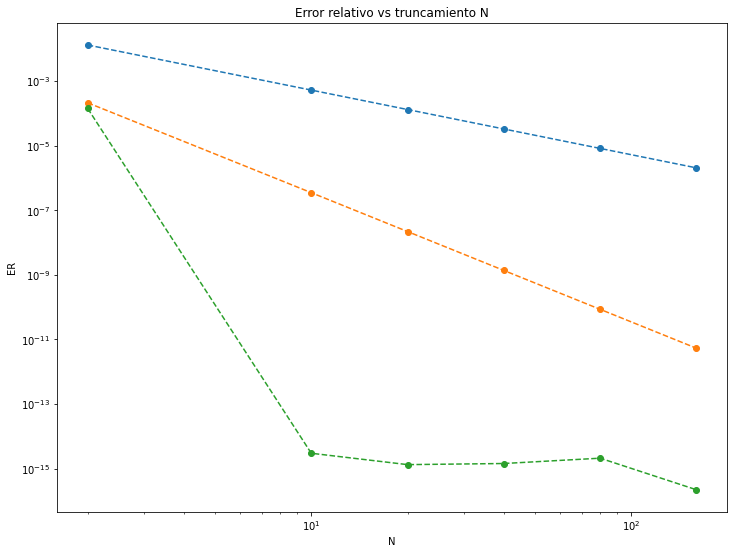

In [ ]:
#graficos========================================================

plt.figure(figsize=(12,9))
plt.title('Error relativo vs truncamiento N')
plt.loglog(N,ERT,'o--',label='$metodo del trapecio$')
plt.loglog(N,ERS,'o--',label='$metodo del Simpson$')
plt.loglog(N,ERG,'o--',label='$metodo de Gauus$')
plt.xlabel('N')
plt.ylabel('ER')